# QuTiP optimization of single-qubit gate in transmon system

## Environment

In [82]:
import qutip
import qutip.control.pulseoptim as cpo
from qutip.qip import hadamard_transform
import numpy as np
import sympy
import sympy.physics.quantum
from sympy import symbols
from functools import partial
import QDYN
from analytical_pulses import ampl_1freq, ampl_1freq_rwa
import matplotlib.pyplot as plt

In [2]:
sympy.init_printing()

In [3]:
%matplotlib inline

In [4]:
GHz    = 2 * np.pi
ns     = 1

In [5]:
class QuTiPEnv():
    """Namespace for use of qutip"""
    def __init__(self):
        self.Sz     = qutip.sigmaz()
        self.Sx     = qutip.sigmax()
        self.Sy     = qutip.sigmay()
        self.Id     = qutip.identity(2)
        self.ket0   = qutip.basis(2, 0)
        self.ket1   = qutip.basis(2, 1)
        self.ket00  = qutip.tensor(self.ket0, self.ket0)
        self.ket01  = qutip.tensor(self.ket0, self.ket1)
        self.ket10  = qutip.tensor(self.ket1, self.ket0)
        self.ket11  = qutip.tensor(self.ket1, self.ket1)
        self.half   = 0.5
        self.two_pi = 2 * np.pi
    @staticmethod
    def tensor(ob1, ob2):
        return qutip.tensor(ob1, ob2)
    @staticmethod
    def overlap(psi1, psi2):
        return psi1.overlap(psi2)
qutip_env = QuTiPEnv()

In [6]:
class SympyEnv():
    """Namespace for use of symbolic algebra"""
    def __init__(self):
        self.Sz     = sympy.Matrix([[1, 0], [0, -1]])
        self.Sx     = sympy.Matrix([[0, 1], [1, 0]])
        self.Sy     = sympy.Matrix([[0, -sympy.I], [sympy.I, 0]])
        self.Id     = sympy.Matrix([[1, 0], [0, 1]])
        self.ket0   = sympy.Matrix([[1,], [0,]])
        self.ket1   = sympy.Matrix([[0,], [1,]])
        self.ket00  = sympy.physics.quantum.TensorProduct(self.ket0, self.ket0)
        self.ket01  = sympy.physics.quantum.TensorProduct(self.ket0, self.ket1)
        self.ket10  = sympy.physics.quantum.TensorProduct(self.ket1, self.ket0)
        self.ket11  = sympy.physics.quantum.TensorProduct(self.ket1, self.ket1)
        self.half   = sympy.Rational(1,2)
        self.two_pi = 2 * sympy.pi
    @staticmethod
    def tensor(ob1, ob2):
        return sympy.physics.quantum.TensorProduct(ob1, ob2)
    @staticmethod
    def overlap(psi1, psi2):
        result = 0
        for a,b in zip(psi1, psi2):
            result += a*b
        return result
sympy_env = SympyEnv()

## Propagation Routines

In [7]:
def propagate(psi0, H, times):
    return qutip.mesolve(H, psi0, times, [], [])

In [8]:
def get_gate(psi, basis, overlap, cls=QDYN.gate2q.Gate2Q):
    """Construct U given psi = [U*ket for ket in basis]
    
    ``overlap(psi1, psi2)`` must evaluate the inner product
    ``<psi1|psi2>``
    """
    U = cls()
    for i in range(4):
        for j in range(4):
            U[i,j] = overlap(basis[i], psi[j])
    return U

In [9]:
def qutip_prop_gate(H, times):
    """Return a list of Gate2Q objects"""
    e = qutip_env
    ket = [e.ket00, e.ket01, e.ket10, e.ket11]
    results = qutip.parallel_map(propagate, ket,
              task_kwargs={'H':H, 'times':times})
    states = [r.states for r in results]
    U = []
    for psi in zip(*states):
       U.append(get_gate(psi, basis=ket, overlap=qutip_env.overlap)) 
    return U

## Hamiltonian Setup

In [10]:
def H_drift(omega_1, omega_2, zeta, env_namespace):
    e = env_namespace
    half = e.half
    hSz = half * e.Sz;
    Id = e.Id
    return (
        - omega_1 * e.tensor(hSz, Id)
        - omega_2 * e.tensor(Id,  hSz)
        - zeta    * e.tensor(hSz, hSz)
        + half * (omega_1 + omega_2 + half*zeta) * e.tensor(Id, Id)
    )

In [11]:
def qutip_RWA_shift(w_d, H_d):
    """Shift the energies of the drift Hamiltonian into the rotating frame"""
    return H_d - qutip.Qobj(np.diag([0, w_d, w_d, 2*w_d]), dims=H_d.dims)

In [12]:
def H_ctrl(lambda_1, lambda_2, lambda_1_2, lambda_2_1, env_namespace):
    e = env_namespace
    Sx = e.Sx; Sz = e.Sz; Id = e.Id
    return (
        lambda_1   * e.tensor(Sx, Id)
      + lambda_2   * e.tensor(Id, Sx)
      - lambda_1_2 * e.tensor(Sx, Sz)
      - lambda_2_1 * e.tensor(Sz, Sx)
    )

## Exemplary field-free evolution

In [19]:
times = np.linspace(0, 10*ns, 100)

U_of_t_ff = qutip_prop_gate(
    H = H_drift(omega_1=  5.9112*GHz,
                omega_2=  6.3721*GHz, 
                zeta   = -0.1498*GHz,
                env_namespace = qutip_env),
    times = times
)

In [20]:
C_ff = [U.concurrence() for U in U_of_t_ff]

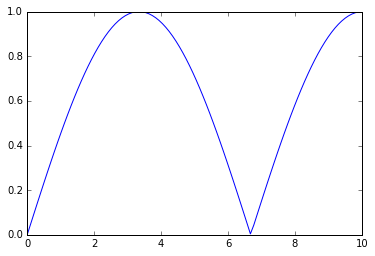

In [21]:
plt.plot(times, C_ff)

## Exemplary evolution in the lab frame

In [72]:
times = np.linspace(0, 10*ns, 500)
w_d = (6.3721 - 0.5*0.1498)*GHz

def epsilon(t, args):
    # note that for frequencies, unit conversion is done inside ampl_1freq
    return ampl_1freq(t, E0=100.0*1e-3*GHz, T=times[-1], w_L=w_d/GHz)

U_of_t = qutip_prop_gate(
    H = [
        H_drift(omega_1=  5.9112*GHz,
                omega_2=  6.3721*GHz, 
                zeta   = -0.1498*GHz,
                env_namespace = qutip_env),
        [H_ctrl(lambda_1   = 4.81e-1,
                lambda_2   = 3.56e-1,
                lambda_1_2 = -4.94e-2,
                lambda_2_1 =  4.2e-2,
                env_namespace = qutip_env),
         epsilon]
        ],
    times = times
)

In [73]:
%%timeit
qutip_prop_gate(
    H = [
        H_drift(omega_1=  5.9112*GHz,
                omega_2=  6.3721*GHz, 
                zeta   = -0.1498*GHz,
                env_namespace = qutip_env),
        [H_ctrl(lambda_1   = 4.81e-1,
                lambda_2   = 3.56e-1,
                lambda_1_2 = -4.94e-2,
                lambda_2_1 =  4.2e-2,
                env_namespace = qutip_env),
         epsilon]
        ],
    times = times
)

1 loop, best of 3: 21.9 s per loop


In [67]:
C = [U.concurrence() for U in U_of_t]

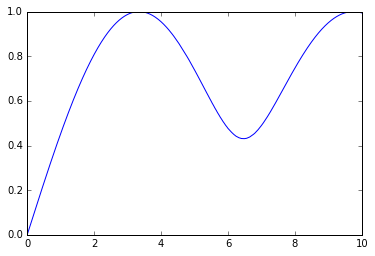

In [68]:
plt.plot(times, C)

In [ ]:
p = QDYN.pulse.Pulse(tgrid=QDYN.pulse.pulse_tgrid

In [ ]:
p = QDYN.pulse.Pulse

## Derivation of the rotating frame

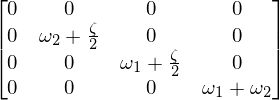

In [26]:
H0_sym = H_drift(omega_1 =  symbols(r'\omega_1', real=True),
        omega_2 =  symbols(r'\omega_2', real=True), 
        zeta    =  symbols(r'\zeta', real=True),
        env_namespace = sympy_env)
H0_sym

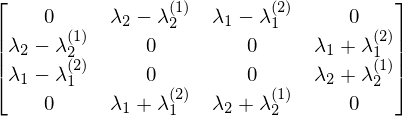

In [27]:
H1_sym = H_ctrl(lambda_1 = symbols(r'\lambda_1', real=True),
       lambda_2 = symbols(r'\lambda_2', real=True),
       lambda_1_2 = symbols(r'\lambda_1^{(2)}', real=True),
       lambda_2_1 = symbols(r'\lambda_2^{(1)}', real=True),
       env_namespace = sympy_env)
H1_sym

In [28]:
def U_RWA(w_d, t):
    """The transformation to the rotating frame"""
    return sympy.Matrix([
            [1, 0, 0, 0],
            [0, sympy.exp(sympy.I * w_d * t), 0, 0],
            [0, 0, sympy.exp(sympy.I * w_d * t), 0],
            [0, 0, 0, sympy.exp(2*sympy.I * w_d * t)]
        ])

In [29]:
def rwa_approximate(expr, eps, w_d, t, S):
    """Perform the approximation eps*e^(-i*w_d*t) -> S/2"""
    rwa_exp = sympy.exp(-sympy.I*w_d*t)
    rwa_exp_dg = sympy.exp(sympy.I*w_d*t)
    def rewrite_mul(*args):
        has_eps = False
        has_rwa_exp = False
        new_args = [S/2, ]
        for arg in args:
            if arg == eps:
                has_eps = True
            elif (arg == rwa_exp) or (arg == rwa_exp_dg):
                has_rwa_exp = True
            else:
                new_args.append(arg)
        if has_eps and has_rwa_exp:
            return sympy.Mul(*new_args)
        else:
            return sympy.Mul(*args)
    return expr.replace(sympy.Mul, rewrite_mul)

In [30]:
def sympy_RWA(H0, H1, eps):
    w_d, t, S = sympy.symbols([r'\omega_d', 't', 'S(t)'], positive=True)
    I = sympy.I
    U = U_RWA(w_d, t)
    H0_RWA = U * H0 * U.H
    H1_RWA = eps * (U * H1 * U.H)
    n = H1_RWA.shape[0]; assert H1_RWA.shape == (n, n)
    for i in range(n):
        for j in range(n):      
            H1_RWA[i,j] = rwa_approximate(H1_RWA[i,j], eps, w_d, t, S)
    shift = I * U.diff(t) * U.H 
    return (shift, H0_RWA, H1_RWA)

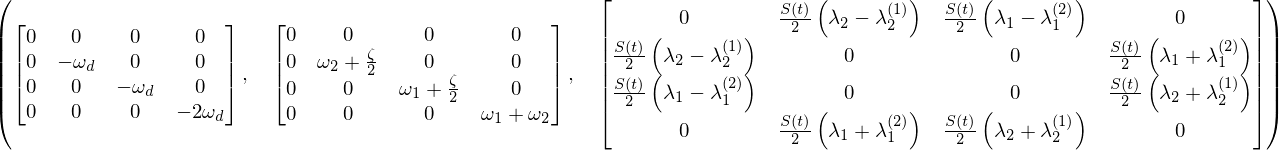

In [31]:
sympy_RWA(H0=H0_sym, H1=H1_sym, eps = sympy.symbols(r'\epsilon(t)', real=True))

## Exemplary evolution in the rotating frame

In [70]:
times = np.linspace(0, 10*ns, 500)

w_d = (6.3721 - 0.5*0.1498)*GHz
E0 = 100.0 # MHz (in the lab frame)

def epsilon_RWA(t, args):
    # note factor 1/2 in the pulse amplitude
    return ampl_1freq_rwa(t, E0=0.5*E0*1e-3*GHz,
                          T=times[-1],
                          w_L=w_d, w_d=w_d)

U_of_t_RWA = qutip_prop_gate(
    H = [
        qutip_RWA_shift(
            w_d,
            H_drift(omega_1 =  5.9112*GHz,
                    omega_2 =  6.3721*GHz, 
                    zeta    = -0.1498*GHz,
                    env_namespace = qutip_env)
            ),
        [H_ctrl(lambda_1   =  4.81e-1,
                lambda_2   =  3.56e-1,
                lambda_1_2 = -4.94e-2,
                lambda_2_1 =  4.20e-2,
                env_namespace = qutip_env),
         # H_ctrl is identical to lab frame, factor 1/2
         # is included in epsilon_RWA
         epsilon_RWA]
        ],
    times = times
)

In [71]:
%%timeit
qutip_prop_gate(
    H = [
        qutip_RWA_shift(
            w_d,
            H_drift(omega_1 =  5.9112*GHz,
                    omega_2 =  6.3721*GHz, 
                    zeta    = -0.1498*GHz,
                    env_namespace = qutip_env)
            ),
        [H_ctrl(lambda_1   =  4.81e-1,
                lambda_2   =  3.56e-1,
                lambda_1_2 = -4.94e-2,
                lambda_2_1 =  4.20e-2,
                env_namespace = qutip_env),
         # H_ctrl is identical to lab frame, factor 1/2
         # is included in epsilon_RWA
         epsilon_RWA]
        ],
    times = times
)

1 loop, best of 3: 15.4 s per loop


In [40]:
U_of_t_RWA_LAB = [QDYN.gate2q.Gate2Q(np.array((U_RWA(w_d, t).H) * U))
                  for (U, t) in zip(U_of_t_RWA, times)]

In [41]:
type(U_RWA(w_d, 0))

sympy.matrices.dense.MutableDenseMatrix

In [42]:
C_RWA = [U.concurrence() for U in U_of_t_RWA]

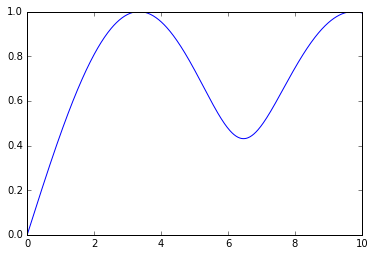

In [43]:
plt.plot(times, C_RWA)

In [44]:
C_RWA_LAB = [U.concurrence() for U in U_of_t_RWA_LAB]

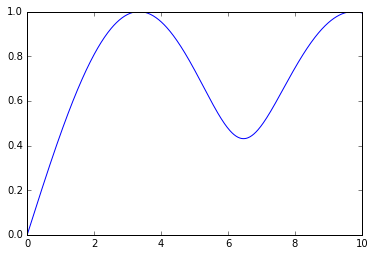

In [45]:
plt.plot(times, C_RWA_LAB)

## Optimization

In [111]:
Hadamard = hadamard_transform(1)
Id = qutip_env.Id
tensor = qutip_env.tensor

In [87]:
w_d = (6.3721 - 0.5*0.1498)*GHz
oct_result = cpo.optimize_pulse_unitary(
    H_d = qutip_RWA_shift(
            w_d,
            H_drift(omega_1 =  5.9112*GHz,
                    omega_2 =  6.3721*GHz, 
                    zeta    = -0.1498*GHz,
                    env_namespace = qutip_env)
        ),
    H_c = [H_ctrl(lambda_1   =  4.81e-1,
                  lambda_2   =  3.56e-1,
                  lambda_1_2 = -4.94e-2,
                  lambda_2_1 =  4.20e-2,
                  env_namespace = qutip_env),],
    U_0 = qutip_env.tensor(Id, Id),
    U_targ = qutip_env.tensor(Hadamard, Id),
    num_tslots = 1000, evo_time = 10*ns,
    amp_lbound = 0.0, amp_ubound = 0.5*GHz
)

The optimized pulse is:

In [101]:
oct_ampl = QDYN.linalg.vectorize(oct_result.final_amps)

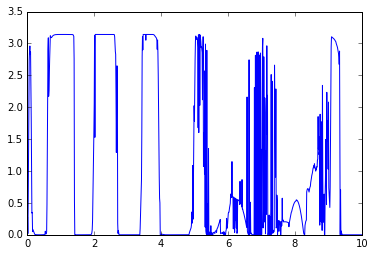

In [102]:
plt.plot(np.linspace(0,10,1000), oct_ampl)

The dynamics under the optimized pulse are:

In [104]:
times = np.linspace(0, 10*ns, 1000)

w_d = (6.3721 - 0.5*0.1498)*GHz
E0 = 100.0 # MHz (in the lab frame)

def epsilon_opt(t, args):
    i = np.digitize(t, times)
    return oct_ampl[i-1]
    

U_of_t_opt = qutip_prop_gate(
    H = [
        qutip_RWA_shift(
            w_d,
            H_drift(omega_1 =  5.9112*GHz,
                    omega_2 =  6.3721*GHz, 
                    zeta    = -0.1498*GHz,
                    env_namespace = qutip_env)
            ),
        [H_ctrl(lambda_1   =  4.81e-1,
                lambda_2   =  3.56e-1,
                lambda_1_2 = -4.94e-2,
                lambda_2_1 =  4.20e-2,
                env_namespace = qutip_env),
         epsilon_opt]
        ],
    times = times
)

In [105]:
C_opt = [U.concurrence() for U in U_of_t_opt]

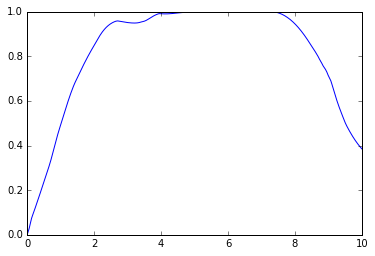

In [106]:
plt.plot(times, C_opt)

In [109]:
U = U_of_t_opt[-1]

In [110]:
U.concurrence()

In [121]:
U.F_avg(QDYN.gate2q.Gate2Q(tensor(Hadamard, Id).full()))